In [1]:
%matplotlib inline

from __future__ import division, print_function

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import SHS_data
import util
import paired_data

reload(paired_data);

## I. Learning Cover Song Fingerprints

This notebook documents an experiment in which we try to learn a fingerprinting function for chroma-based cover song retrieval.

It relies on three other modules in this project for data handling: `SHS_data` (to load Second Hand Song chroma features and ground truth), `paired_data` (to preprocess data for training a neural network) and `util`.

The cover detection experiment in the next section uses `main` for the experiment routines and `fingerprints`, which contains other fingerprinting functions to which we can compare.

But first, this section presents the fingerprint learning, in three parts:

1. Data - loading train and test data to memory

1. Network components - defining network variables and layers
    
1. Network - setting up a three-layer convolutional neural network

1. Training - training (and testing) the network

### 1. Data

#### load training data

In [2]:
# train, test, validation split
ratio = (50,20,30)
clique_dict, _ = SHS_data.read_cliques()
train_cliques, test_cliques_big, _ = util.split_train_test_validation(clique_dict, ratio=ratio)

# preload training data to memory (just about doable)
print('Preloading training data...')
train_uris = util.uris_from_clique_dict(train_cliques)
chroma_dict = SHS_data.preload_chroma(train_uris)

# make a training dataset of cover and non-cover pairs of songs
print('Preparing training dataset...')
n_patches, patch_len = 8, 64
X_A, X_B, Y, pair_uris = paired_data.dataset_of_pairs(train_cliques, chroma_dict,
                                                             n_patches=n_patches, patch_len=patch_len)
print('    Training set:', X_A.shape, X_B.shape, Y.shape)

Preloading training data...
Preparing training dataset...
    Training set: (32436, 512, 12) (32436, 512, 12) (32436, 1)


#### load test data

for now, load just a small part of the test set that we'll evaluate at every iteration, e.g., a few times batch size

In [3]:
# pick a test subset
n_test_cliques = 50  # e.g., 50 ~ small actual datasets
test_cliques = {uri: test_cliques_big[uri] for uri in test_cliques_big.keys()[:n_test_cliques]}

# preload test data to memory (just about doable)
print('Preloading test data...')
test_uris = util.uris_from_clique_dict(test_cliques)
chroma_dict_T = SHS_data.preload_chroma(test_uris)

# make a test dataset of cover and non-cover pairs of songs
print('Preparing test dataset...')
X_A_T, X_B_T, Y_T, test_pair_uris_T = paired_data.dataset_of_pairs(test_cliques, chroma_dict_T,
                                                             n_patches=n_patches, patch_len=patch_len)
print('    Test set:', X_A_T.shape, X_B_T.shape, Y_T.shape)

Preloading test data...
Preparing test dataset...
    Test set: (340, 512, 12) (340, 512, 12) (340, 1)


### 2. Network Components

#### variables

In [144]:
weight_scale = 0.1

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=weight_scale)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(weight_scale, shape=shape)
    return tf.Variable(initial)

#### layers

In [145]:
# convolutional layers
def conv_bins(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def conv_frames(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# max pool layers
def max_pool_4x1(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 1, 1],
                          strides=[1, 4, 1, 1], padding='SAME')

def max_pool_8x1(x):
    return tf.nn.max_pool(x, ksize=[1, 8, 1, 1],
                          strides=[1, 8, 1, 1], padding='SAME')

def max_pool_16x1(x):
    return tf.nn.max_pool(x, ksize=[1, 16, 1, 1],
                          strides=[1, 16, 1, 1], padding='SAME')

### 3. Network

#### input

In [146]:
input_len = n_patches * patch_len

x_A = tf.placeholder("float", shape=[None, input_len, 12])
x_B = tf.placeholder("float", shape=[None, input_len, 12])
y_ = tf.placeholder("float", shape=[None,])

x_image_A = tf.reshape(x_A, [-1, input_len, 12, 1])
x_image_B = tf.reshape(x_B, [-1, input_len, 12, 1])
y_ = tf.reshape(y_, [-1, 1])

#### conv layer 1

`(512, 12, 1) > (128, 1, 32)`

In [147]:
W_conv1 = weight_variable([1, 12, 1, 32])
b_conv1 = bias_variable([32])

h_conv1_A = tf.nn.relu(conv_bins(x_image_A, W_conv1) + b_conv1)
h_conv1_B = tf.nn.relu(conv_bins(x_image_B, W_conv1) + b_conv1)

h_pool1_A = max_pool_4x1(h_conv1_A)
h_pool1_B = max_pool_4x1(h_conv1_B)

#### conv layer 2

`(128, 1, 32) > (8, 1, 64)`

`64x1` max-pooling is used to pool at once across the last convolution (`8x1`) and the `8` patches of chroma of which the input features is made.

In [148]:
W_conv2 = weight_variable([2, 1, 32, 64])
b_conv2 = bias_variable([64])

h_conv2_A = tf.nn.relu(conv_frames(h_pool1_A, W_conv2) + b_conv2)
h_conv2_B = tf.nn.relu(conv_frames(h_pool1_B, W_conv2) + b_conv2)

h_pool2_A = max_pool_16x1(h_conv2_A)
h_pool2_B = max_pool_16x1(h_conv2_B)

#### fully connected layer

`(8, 1, 64) > (128)`

max-pool over patches and flatten

In [176]:
h_pool2_A_flat = tf.reshape(h_pool2_A, [-1, 8*64])  # flatten images first
h_pool2_B_flat = tf.reshape(h_pool2_B, [-1, 8*64])

W_fc1 = weight_variable([8*64, 128])
b_fc1 = bias_variable([128])

out_I_A = tf.tanh(tf.matmul(h_pool2_A_flat, W_fc1) + b_fc1)
out_I_B = tf.tanh(tf.matmul(h_pool2_B_flat, W_fc1) + b_fc1)

# h_fc1_A = tf.nn.relu(tf.matmul(h_pool2_A_flat, W_fc1) + b_fc1)
# h_fc1_B = tf.nn.relu(tf.matmul(h_pool2_B_flat, W_fc1) + b_fc1)

# out_I_A = tf.tanh(h_pool2_A_flat)
# out_I_B = tf.tanh(h_pool2_B_flat)

#### Bhattacharyya distance

In [177]:
def approx_bhattacharyya(squared_dists, is_cover):
    """Approximate bhattacharyya distance between cover and non-cover distances.
    
    Similar to Mahalanobis distance, but for distributions with different variances.
    Assumes normality, hence approximate (distances are bound by 0).
    """
    pair_dists = np.sqrt(squared_dists[np.where(is_cover==1)])
    non_pair_dists = np.sqrt(squared_dists[np.where(is_cover==0)])
    
    mu_pairs, sigma2_pairs = np.mean(pair_dists), np.var(pair_dists)
    mu_non_pairs, sigma2_non_pairs = np.mean(non_pair_dists), np.var(non_pair_dists)

    bhatt = (0.25 * np.log(0.25 * (sigma2_pairs/sigma2_non_pairs + sigma2_non_pairs/sigma2_pairs + 2)) +
             0.25 * (mu_pairs - mu_non_pairs)**2 / (sigma2_pairs + sigma2_non_pairs))
    return bhatt, mu_pairs, mu_non_pairs

### 4. Training

#### objective function

Minize pair distances while maximizing non-pair distances smaller than `m`

Following [1].

1. Raffel, C., & Ellis, D. P. W. (2015). Large-Scale Content-Based Matching of Midi and Audio Files. Proceedings of the 16th International Society for Music Information Retrieval Conference (ISMIR), 234–240.

In [178]:
alpha = 1
m = 10

squared_errors = tf.reduce_sum(tf.square(out_I_A - out_I_B), reduction_indices=1, keep_dims=True)
pair_loss = tf.reduce_mean(y_ * squared_errors)
non_pair_loss = tf.reduce_mean((1 - y_) * tf.square(tf.maximum(0.0, m - tf.sqrt(squared_errors))))

loss_function = pair_loss + (alpha * non_pair_loss)
loss_float = tf.cast(loss_function, "float")

# optimizer
learning_rate = tf.placeholder(tf.float32, shape=[])
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)

#### init basic logging

In [179]:
error_pairs_log = []
error_non_pairs_log = []

squared_dists_log = []
labels_log = []
d_pairs_log = []
d_non_pairs_log = []

train_error_log = []
train_bhatt_log = []

test_error_log = []
test_bhatt_log = []

#### reporting

bundle all logging and printing into a function

In [180]:
def report(step, batch):
    print('step {}'.format(step))

    # train and test feeds
    train_feed = {x_A:batch[0], x_B:batch[1], y_: batch[2]}
    test_feed = {x_A:X_A_T, x_B:X_B_T, y_: Y_T}
    
    # train metrics
    error_pairs, error_non_pairs, squared_dists, train_error = sess.run([pair_loss, non_pair_loss,
                                                                        squared_errors, loss_float],
                                                                        feed_dict=train_feed)
    train_bhatt, d_pairs, d_non_pairs = approx_bhattacharyya(squared_dists, train_feed[y_])
    
    # test metrics
    test_squared_dists, test_error = sess.run([squared_errors, loss_float],
                                              feed_dict=test_feed)
    test_bhatt, _, _ = approx_bhattacharyya(test_squared_dists, test_feed[y_])

    # log all metrics
    error_pairs_log.append(error_pairs)
    error_non_pairs_log.append(error_non_pairs)
    squared_dists_log.append(squared_dists)
    labels_log.append(batch[2])
    d_non_pairs_log.append(d_non_pairs)
    d_pairs_log.append(d_pairs)
    train_bhatt_log.append(train_bhatt)
    train_error_log.append(train_error)
    test_bhatt_log.append(test_bhatt)    
    test_error_log.append(test_error)
    
    # print some metrics
    print('  d_pairs, d_non_pairs = %.3g, %.3g' % (d_pairs, d_non_pairs))
    print('  train error %.3g, train bhatt %.3g' % (train_error, train_bhatt))
    print('  test error %.3g, test bhatt %.3g' % (test_error, test_bhatt))

#### initialize session

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

#### train

In [ ]:
n_epoques = 2500    # 2500 ~ 10 x training set after (50,20,30) split
batch_size = 100
lr = 3e-4

train_batches = paired_data.get_batches([X_A, X_B, Y], batch_size=batch_size)
for step in range(n_epoques):  
    batch = next(train_batches)
    if step%10 == 0:
        report(step, batch)
    train_feed = {x_A:batch[0], x_B:batch[1], y_: batch[2], learning_rate: lr}
    train_step.run(feed_dict=train_feed)
report('[end]', batch)

typical result:

    step [end]
      d_pairs, d_non_pairs = 3.47, 5.71
      train error 17.2, train bhatt 0.335
      test error 19.5, test bhatt 0.155

#### plot loss function 

plot loss functions for train and test data.

**Note**: test error is computed for the same subset at every step, making it appear much more stable than the training loss (computed for a different batch at every step).

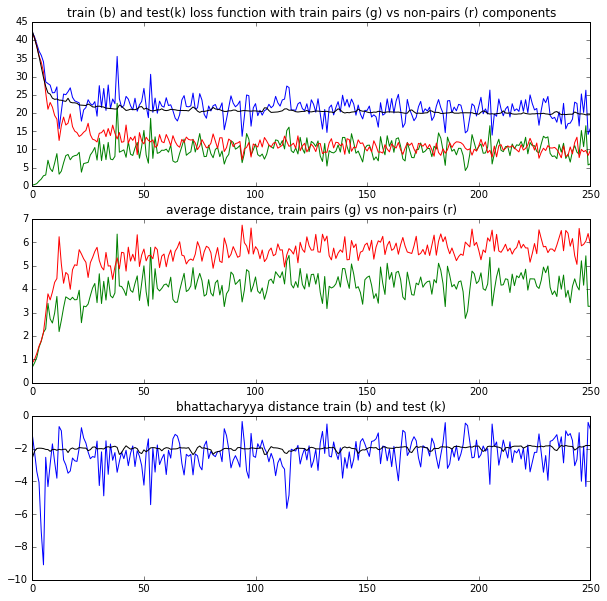

In [183]:
plt.figure(figsize=(10,10))

plt.subplot(311)
plt.plot(train_error_log);
plt.plot(error_pairs_log, color='g');
plt.plot(error_non_pairs_log, color='r');
plt.plot(test_error_log, color='k');
plt.title('train (b) and test(k) loss function with train pairs (g) vs non-pairs (r) components');

plt.subplot(312)
plt.plot(d_pairs_log, color='g');
plt.plot(d_non_pairs_log, color='r');
plt.title('average distance, train pairs (g) vs non-pairs (r)');

plt.subplot(313)
plt.plot(np.log(train_bhatt_log));
plt.plot(np.log(test_bhatt_log), 'k');
plt.title('bhattacharyya distance train (b) and test (k)');

#### train distances

bhatt = (0.44105542530956371, 3.267107, 5.9225645)


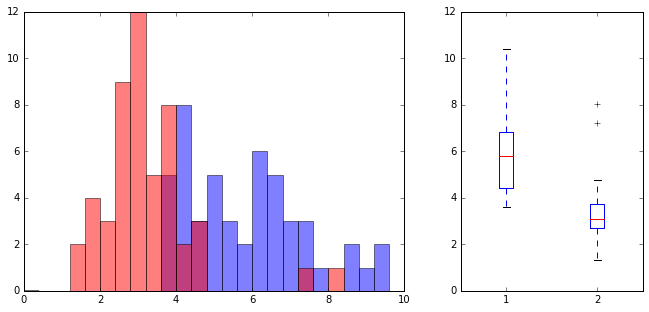

In [184]:
pair_dists = np.sqrt(squared_dists_log[-1][np.where(labels_log[-1]==1)])
non_pair_dists = np.sqrt(squared_dists_log[-1][np.where(labels_log[-1]==0)])
L1 = pair_loss.eval(feed_dict={x_A:batch[0], x_B:batch[1], y_:batch[2]})
L2 = non_pair_loss.eval(feed_dict={x_A:batch[0], x_B:batch[1], y_:batch[2]})

bins = np.arange(0,10,0.4)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(non_pair_dists, bins=bins, alpha=0.5);
plt.hist(pair_dists, bins=bins, color='r', alpha=0.5);
plt.subplot(143)
plt.boxplot([non_pair_dists, pair_dists]);

print('bhatt =', approx_bhattacharyya(squared_dists_log[-1], labels_log[-1]))

#### test distances

bhatt = (0.1623162238405052, 4.1065464, 6.1284294)


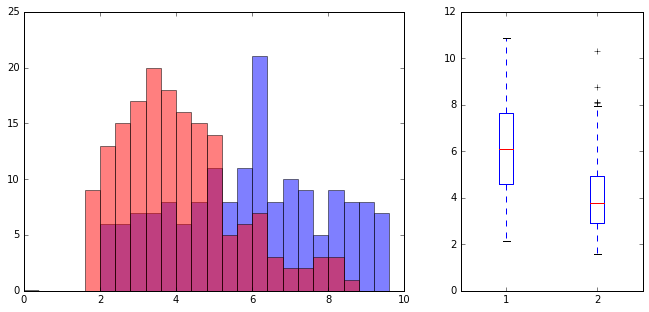

In [185]:
test_squared_dists = squared_errors.eval(feed_dict={x_A:X_A_T, x_B:X_B_T})
test_squared_dists = np.sum(test_squared_dists, axis=1)

test_pair_dists = np.sqrt(test_squared_dists[np.where(Y_T==1)[0]])
test_non_pair_dists = np.sqrt(test_squared_dists[np.where(Y_T==0)[0]])

bins = np.arange(0,10,0.4)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(test_non_pair_dists, bins=bins, alpha=0.5);
plt.hist(test_pair_dists, bins=bins, color='r', alpha=0.5);
plt.subplot(143)
plt.boxplot([test_non_pair_dists, test_pair_dists]);

print('bhatt =', approx_bhattacharyya(test_squared_dists, Y_T.flatten()))

## II. Test Experiment

Run a cover detection experiment on some of the Second Hand Song data, using the modules implemented before. We simply pass `fingerprint()`, a wrapper function around `out_I_A.eval()`, to `main.run_leave_one_out_experiment()`.

First, however, we compute some baseline performances using existing fingerprinting methods (see `fingerprints` documentation).

In [186]:
import main
import fingerprints as fp

###  1. Results for static fingerprints

**Note**: there are some issues with short chroma files when computing the fingerprinting functions in `fingerprints`  for the complete 20% test set.
For now, we will be using only the very short dataset that is `test_cliques`.

In [207]:
results = main.run_leave_one_out_experiment(test_cliques,
                                            fp_function=fp.cov,
                                            print_every=50)
print('results:', results)

Computing fingerprints...
    Fingerprinting track 50/141...
    Fingerprinting track 100/141...
Running queries...
    Running queries for clique 50/50
results: {'mean r5': 0.22659574468085109, 'mean ap': 0.19774902881386611, 'mean p1': 0.14184397163120568}


In [205]:
results = main.run_leave_one_out_experiment(test_cliques,
                                            fp_function=fp.fourier,
                                            print_every=50)
print('results:', results)

Computing fingerprints...
    Fingerprinting track 50/141...
    Fingerprinting track 100/141...
Running queries...
    Running queries for clique 50/50
results: {'mean r5': 0.3851063829787234, 'mean ap': 0.35797756949792087, 'mean p1': 0.39007092198581561}


#### `fp.cov`

results: {'mean r5': 0.22659574468085109, 'mean ap': 0.19774902881386611, 'mean p1': 0.14184397163120568}

#### `fp.fourier`

results: {'mean r5': 0.3851063829787234, 'mean ap': 0.35797756949792087, 'mean p1': 0.39007092198581561}

### 2. Results for learned fingerprints

In [201]:
def fingerprint(chroma, n_patches=8, patch_len=64):
    patchwork = paired_data.patchwork(chroma, n_patches=n_patches,
                                      patch_len=patch_len)
    fps = []
    for i in range(12):
        patchwork_trans = np.roll(patchwork, -i, axis=1)
        patchwork_tensor = patchwork_trans.reshape((1, n_patches*patch_len, 12))
        fp = sess.run(out_I_A, feed_dict={x_A : patchwork_tensor})
        fps.append(fp.flatten())
    return fps

In [202]:
results = main.run_leave_one_out_experiment(test_cliques,
                                            fp_function=fingerprint,
                                            print_every=50)
print('results:', results)

Computing fingerprints...
    Fingerprinting track 50/141...
    Fingerprinting track 100/141...
Running queries...
    Running queries for clique 50/50
results: {'mean r5': 0.22872340425531915, 'mean ap': 0.21106169953170131, 'mean p1': 0.1773049645390071}


#### 1x12x32-2x1x64-128 network

results: {'mean r5': 0.22872340425531915, 'mean ap': 0.21106169953170131, 'mean p1': 0.1773049645390071}

#### conclusion

- *outperforms covariance-based fingerprints*
    (most clearly in terms of precision)

- *but not fingerprints based on the 2D-fourier-transform*